In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

In [ ]:
local_zip = '/content/DATASET.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/waste-classification-data/')
zip_ref.close()

In [ ]:
# Directory Location
data_dir = '/content/waste-classification-data/DATASET/'

In [ ]:
# lihat jumlah file
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('Directory:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('Total files in directory:', files_counter)

print('--------')
print('Total number of files',total_files)
print('Total number of directory',total_dir)

counting: /content/waste-classification-data/DATASET/
total files in dir: 0
counting: /content/waste-classification-data/DATASET/.ipynb_checkpoints
total files in dir: 0
counting: /content/waste-classification-data/DATASET/O
total files in dir: 13966
counting: /content/waste-classification-data/DATASET/R
total files in dir: 11111
--------
total number of files 25077
total number of directories 3


In [ ]:
# buat dataset untuk training dan validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 25077 files belonging to 2 classes.
Using 20062 files for training.
Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


In [ ]:
# lihat nama kelas
class_names = train_ds.class_names
print(class_names)

['O', 'R']


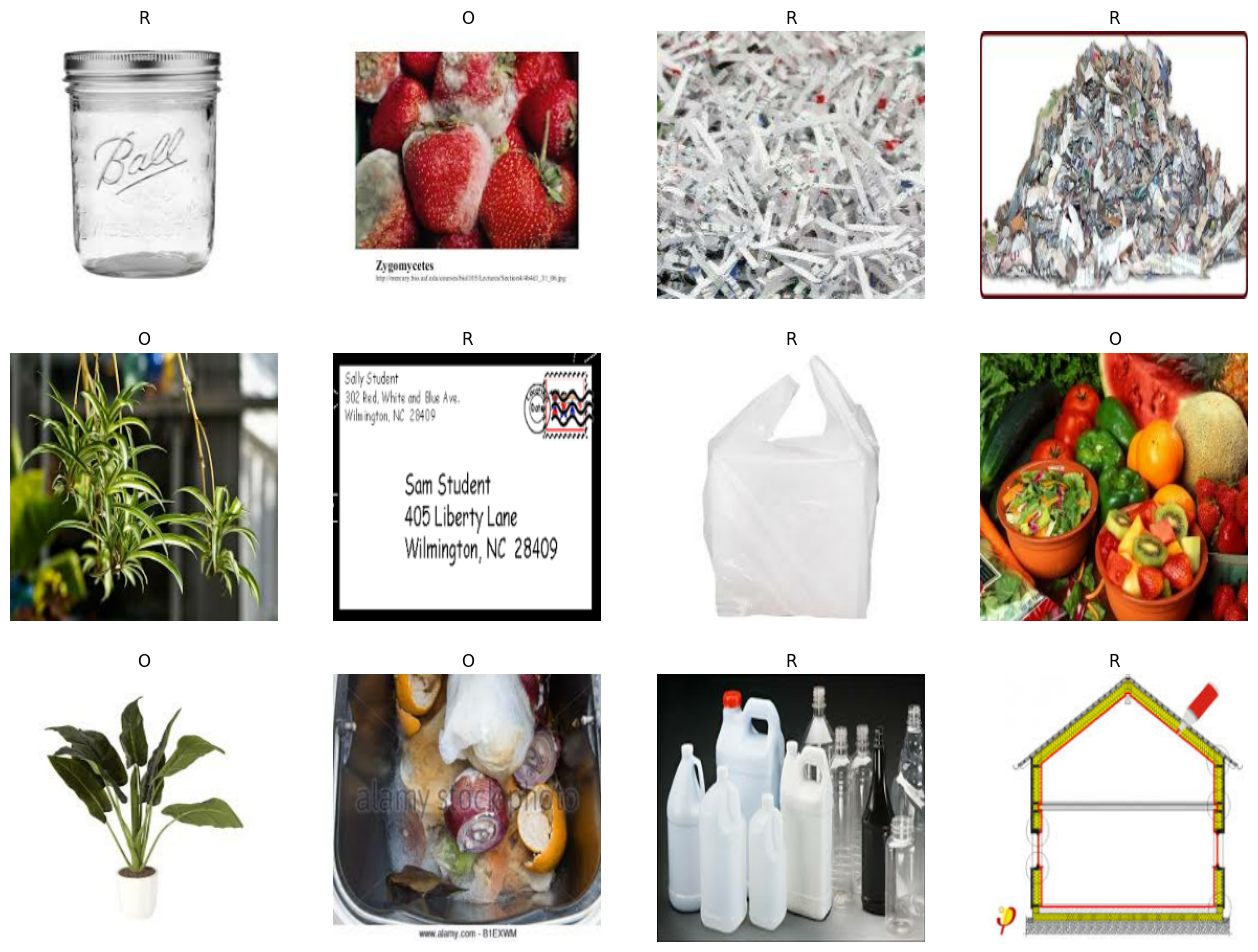

In [ ]:
# lihat beberapa gambar dari train_ds
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

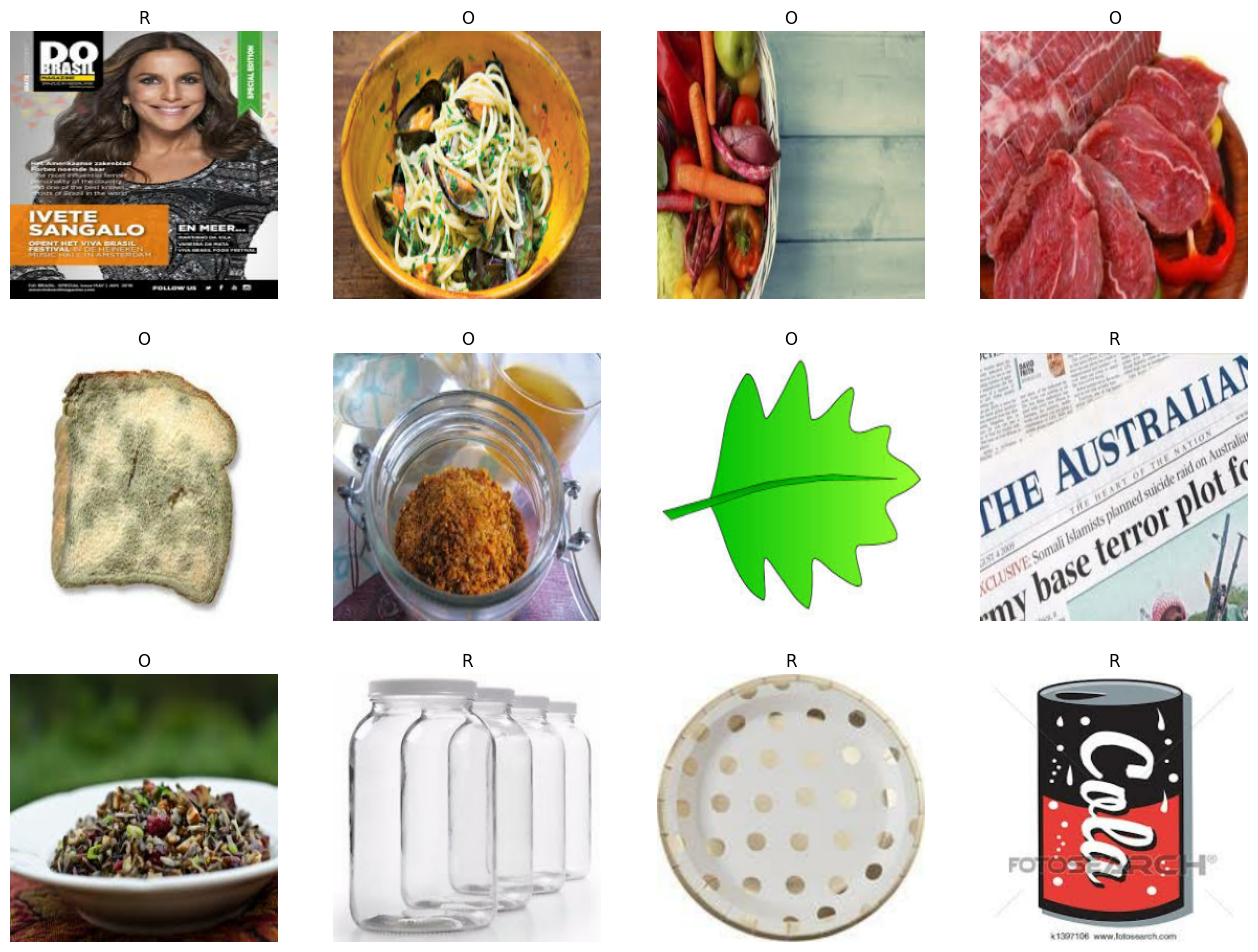

In [ ]:
# lihat beberapa gambar dari validation_ds
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# inspect train_ds
train_batch = train_ds.as_numpy_iterator().next()

print('Total of batches:',len(train_ds))
print('Images batch shape:',train_batch[0].shape)
print('Labels batch shape:',train_batch[1].shape)

total of batches: 627
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [ ]:
# inspect validation_ds
validation_batch = validation_ds.as_numpy_iterator().next()

print('Total of batches:',len(validation_ds))
print('Images batch shape:',validation_batch[0].shape)
print('Labels batch shape:',validation_batch[1].shape)

total of batches: 157
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [ ]:
# base model
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)

# layer model trainable untuk tunning
base_model.trainable = True

In [ ]:
# arsitektur model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 190


In [ ]:
# tuning layer dan indeksnya
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# tuning
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# augmentasi
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [ ]:
# arsitektur neural network
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00001
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)

In [ ]:
# train model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
627/627 [==============================] - 135s 198ms/step - loss: 0.2753 - accuracy: 0.8905 - val_loss: 0.1690 - val_accuracy: 0.9416
Epoch 2/10
627/627 [==============================] - 123s 195ms/step - loss: 0.1731 - accuracy: 0.9355 - val_loss: 0.1409 - val_accuracy: 0.9486
Epoch 3/10
627/627 [==============================] - 123s 195ms/step - loss: 0.1503 - accuracy: 0.9439 - val_loss: 0.1317 - val_accuracy: 0.9521
Epoch 4/10
627/627 [==============================] - 119s 190ms/step - loss: 0.1318 - accuracy: 0.9515 - val_loss: 0.1233 - val_accuracy: 0.9553
Epoch 5/10
627/627 [==============================] - 119s 189ms/step - loss: 0.1183 - accuracy: 0.9557 - val_loss: 0.1213 - val_accuracy: 0.9575
Epoch 6/10
627/627 [==============================] - 119s 189ms/step - loss: 0.1050 - accuracy: 0.9612 - val_loss: 0.1193 - val_accuracy: 0.9573
Epoch 7/10
627/627 [==============================] - 119s 189ms/step - loss: 0.0908 - accuracy: 0.9681 - val_loss: 0.1193 -

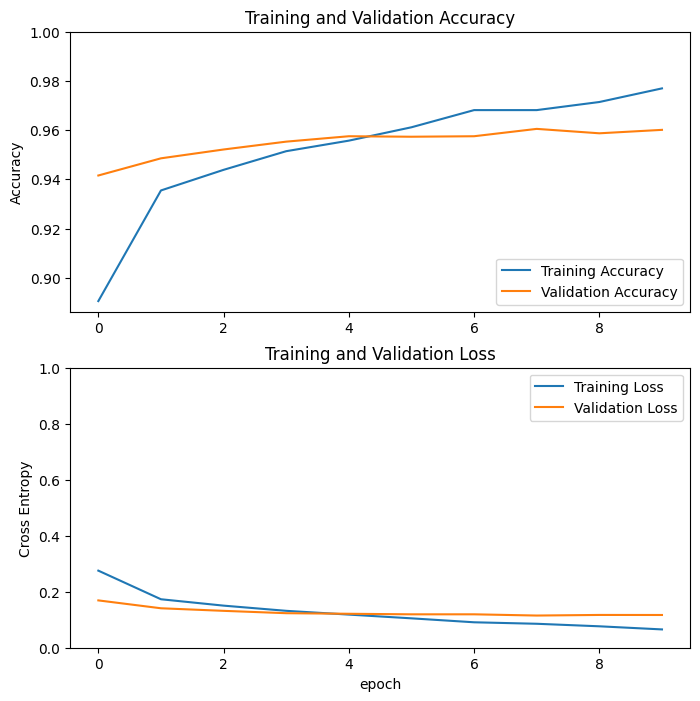

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# performa model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

157/157 [==============================] - 17s 107ms/step - loss: 0.1169 - accuracy: 0.9601
Test accuracy : 0.9601196646690369
Test loss: 0.1169070452451706


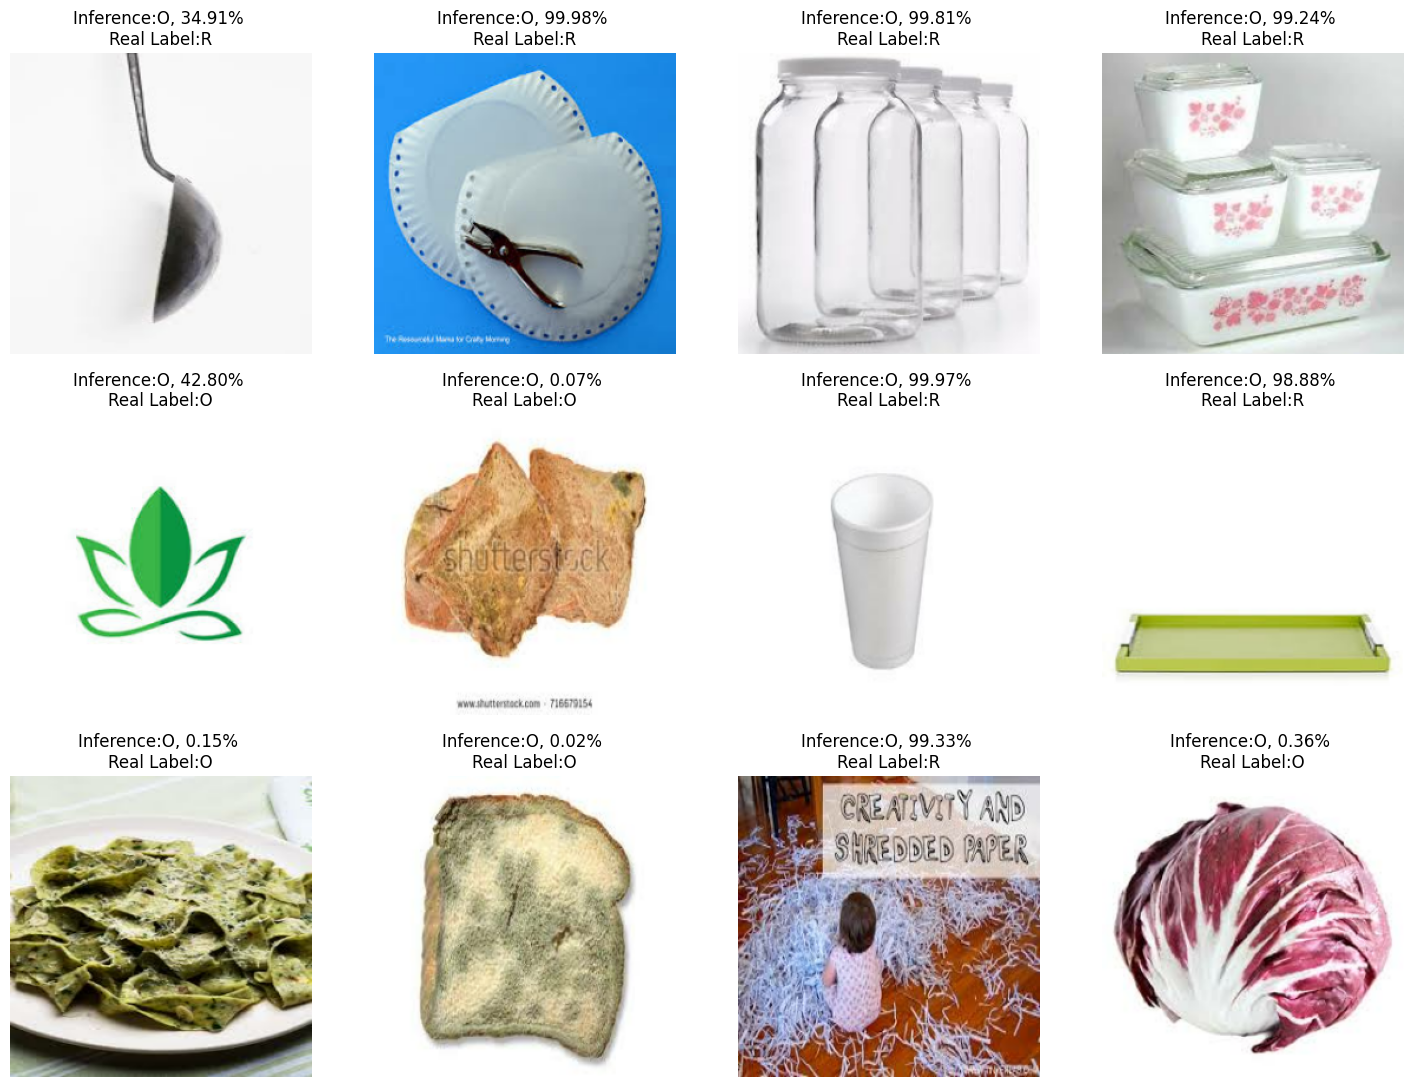

In [ ]:
# predict dari dataset
image_batch, label_batch = validation_ds.as_numpy_iterator().next()

inference = model.predict_on_batch(image_batch)

plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% \nReal Label:{}'
              .format(class_names[np.argmax(inference[i])], 100 * np.max(inference[i]), class_names[label_batch[i]]))
    plt.axis("off")

In [ ]:
model.save('model_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pathlib

export_dir = '/content/MODEL_3'

tf.saved_model.save(model, export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/content/model_3.tflite')
tflite_model_file.write_bytes(tflite_model)

24059296

In [ ]:
tf.saved_model.save(model, '/content/MODEL_3')